# Stage 1
## Framework preparing





In [ ]:
# # uncomment and run!
# !git clone https://github.com/huggingface/diffusers
# !pip install -r /content/diffusers/examples/text_to_image/requirements.txt

# !accelerate config default
# !mv /root/.cache/huggingface/accelerate/default_config.yaml /content/
# !mv /content/default_config.yaml /root/.cache/huggingface/accelerate/
# !accelerate config update

# !pip install accelerate
# !pip install git+https://github.com/huggingface/diffusers

# !pip install wandb

In [ ]:
from accelerate.utils import write_basic_config

write_basic_config()

Configuration already exists at /root/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


False

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb
wandb.init()

wandb: Currently logged in as: valerizab (valerizabby). Use `wandb login --relogin` to force relogin


In [ ]:
import torch

device = torch.device("cuda")

print('There are %d GPU(s) available.' % torch.cuda.device_count())

gpu_name = torch.cuda.get_device_name(0)

print('We will use the GPU:', gpu_name)

def gpu_mem():
    mem = torch.cuda.mem_get_info()
    mb = list(map(lambda x:x/pow(2,20),mem))
    total = mb[1]
    used = mb[1]-mb[0]
    return used,total

def gpu_mem_info(title = ''):
    used,total = gpu_mem()
    print(f'{title} gpu mem : {used:.1f}/{total:.1f} mb')


gpu_mem_info()

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
 gpu mem : 103.0/15101.8 mb


# Stage 2

## 🥰 Experiments : 10 steps

Let's conduct a series of experiments with different fine-tuning parameters. This is a test series, we will process only 10 steps in order to obtain preliminary results on computational costs in case of different parameters configurations.

Parameters I want to check:
- `mixed_precision="fp16" / No`
- `gradient_checkpointing`: True/False
- `resolution`: $512 \to 256$

All result are tracked in wandb and accesed by link for [experiments](https://wandb.ai/valerizabby/text2image-fine-tune?workspace=user-valerizab) and [fine-tuning on custom data](https://wandb.ai/valerizabby/dreambooth-lora?workspace=user-valerizab).

## Experiment 1

- `mixed_precision="fp16"`
- `gradient_checkpointing`: False
- `resolution`: $512$

In [ ]:
def fine_tune():
    !accelerate launch --mixed_precision="fp16"  diffusers/examples/text_to_image/train_text_to_image_lora.py \
    --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
    --dataset_name="lambdalabs/pokemon-blip-captions" \
    --dataloader_num_workers=8 \
    --resolution=512 --center_crop --random_flip \
    --train_batch_asize=1 \
    --gradient_accumulation_steps=4 \
    --max_train_steps=10 \
    --num_train_epochs 1 \
    --learning_rate=1e-04 \
    --max_grad_norm=1 \
    --lr_scheduler="cosine" --lr_warmup_steps=0 \
    --output_dir="/sddata/finetune/lora/pokemon" \
    --push_to_hub \
    --report_to=wandb \
    --checkpointing_steps=500 \
    --validation_prompt="A pokemon with blue eyes." \
    --seed=1337

In [ ]:
fine_tune()

2023-05-14 08:36:38.330307: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-14 08:36:44.574451: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:258: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
05/14/2023 08:36:46 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'dynamic_thresholding_ratio', 'prediction_type', 'variance_type', 'thresholding', 'sample_max_value', 'clip_sample_range'} was not found in config. Values will be initialized to default values.
{'scaling_factor'} was not found in config. Values will be initialized to default values.
{'resnet_skip_time_act', 'addition_embed_type_num_heads', 'time_embedding_type', 'class

## Experiment 2

- `mixed_precision="fp16"`
- `gradient_checkpointing`: False
- `resolution`: $256$

In [ ]:
def fine_tune():
    !accelerate launch --mixed_precision="fp16"  /content/diffusers/examples/text_to_image/train_text_to_image_lora.py \
    --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
    --dataset_name="lambdalabs/pokemon-blip-captions" \
    --dataloader_num_workers=8 \
    --resolution=256 --center_crop --random_flip \
    --train_batch_size=1 \
    --gradient_accumulation_steps=4 \
    --max_train_steps=10 \
    --num_train_epochs 1 \
    --learning_rate=1e-04 \
    --max_grad_norm=1 \
    --lr_scheduler="cosine" --lr_warmup_steps=0 \
    --output_dir="/sddata/finetune/lora/pokemon" \
    --push_to_hub \
    --report_to=wandb \
    --checkpointing_steps=5 \
    --validation_prompt="A pokemon with blue eyes." \
    --seed=1337

In [ ]:
fine_tune()

2023-05-14 09:37:02.455133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-14 09:37:08.544407: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:258: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
05/14/2023 09:37:10 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'thresholding', 'dynamic_thresholding_ratio', 'sample_max_value', 'prediction_type', 'variance_type', 'clip_sample_range'} was not found in config. Values will be initialized to default values.
{'scaling_factor'} was not found in config. Values will be initialized to default values.
{'only_cross_attention', 'resnet_time_scale_shift', 'class_embed_type', 'resnet_out_sca

## Expetiment 3

- `mixed_precision="fp16"`
- `gradient_checkpointing`: True
- `resolution`: $256$

In [ ]:
def fine_tune():
    !accelerate launch --mixed_precision="fp16"  /content/diffusers/examples/text_to_image/train_text_to_image_lora.py \
    --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
    --dataset_name="lambdalabs/pokemon-blip-captions" \
    --dataloader_num_workers=8 \
    --resolution=256 --center_crop --random_flip \
    --train_batch_size=1 \
    --gradient_accumulation_steps=4 \
    --max_train_steps=10 \
    --num_train_epochs 1 \
    --learning_rate=1e-04 \
    --gradient_checkpointing \
    --max_grad_norm=1 \
    --lr_scheduler="cosine" --lr_warmup_steps=0 \
    --output_dir="/sddata/finetune/lora/pokemon" \
    --push_to_hub \
    --report_to=wandb \
    --checkpointing_steps=5 \
    --validation_prompt="A pokemon with blue eyes." \
    --seed=1337

In [ ]:
fine_tune()

2023-05-14 09:46:02.745237: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-14 09:46:08.243302: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:258: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
05/14/2023 09:46:10 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'prediction_type', 'thresholding', 'variance_type', 'dynamic_thresholding_ratio', 'clip_sample_range', 'sample_max_value'} was not found in config. Values will be initialized to default values.
{'scaling_factor'} was not found in config. Values will be initialized to default values.
{'time_cond_proj_dim', 'class_embeddings_concat', 'conv_out_kernel', 'class_embed_type'

## Expetiment 4: 

- `mixed_precision="No`
- `gradient_checkpointing`: True
- `resolution`: $256$

In [ ]:
def fine_tune():
    !accelerate launch /content/diffusers/examples/text_to_image/train_text_to_image_lora.py \
    --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
    --dataset_name="lambdalabs/pokemon-blip-captions" \
    --dataloader_num_workers=8 \
    --resolution=256 --center_crop --random_flip \
    --train_batch_size=1 \
    --gradient_accumulation_steps=4 \
    --max_train_steps=10 \
    --num_train_epochs 1 \
    --learning_rate=1e-04 \
    --gradient_checkpointing \
    --max_grad_norm=1 \
    --lr_scheduler="cosine" --lr_warmup_steps=0 \
    --output_dir="/sddata/finetune/lora/pokemon" \
    --push_to_hub \
    --report_to=wandb \
    --checkpointing_steps=5 \
    --validation_prompt="A pokemon with blue eyes." \
    --seed=1337

In [ ]:
fine_tune()

2023-05-14 09:55:39.576062: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-14 09:55:47.951993: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:258: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
05/14/2023 09:55:50 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

{'sample_max_value', 'dynamic_thresholding_ratio', 'variance_type', 'thresholding', 'clip_sample_range', 'prediction_type'} was not found in config. Values will be initialized to default values.
{'scaling_factor'} was not found in config. Values will be initialized to default values.
{'resnet_skip_time_act', 'time_embedding_act_fn', 'mid_block_type', 'resnet_time_scale_sh

## ⏰ Long-term experiments : 100 steps

### Experiment 1
- `mixed_precision="fp16"`
- `resolution=512`
- `gradient_checkpointing`
- `max_train_steps=100`
- `num_train_epochs 1`

In [ ]:
def fine_tune_1():
    !accelerate launch --mixed_precision="fp16"  /content/diffusers/examples/text_to_image/train_text_to_image_lora.py \
    --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
    --dataset_name="lambdalabs/pokemon-blip-captions" \
    --dataloader_num_workers=8 \
    --resolution=512 --center_crop --random_flip \
    --train_batch_size=1 \
    --gradient_accumulation_steps=4 \
    --max_train_steps=100 \
    --num_train_epochs 1 \
    --learning_rate=1e-04 \
    --gradient_checkpointing \
    --max_grad_norm=1 \
    --lr_scheduler="cosine" --lr_warmup_steps=0 \
    --output_dir="/sddata/finetune/lora/pokemon" \
    --push_to_hub \
    --report_to=wandb \
    --checkpointing_steps=50 \
    --validation_prompt="Smiling pokemon with red eyes." \
    --seed=1337

In [ ]:
fine_tune_1()

2023-05-14 10:36:10.259372: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-14 10:36:16.596862: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:258: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
05/14/2023 10:36:19 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'thresholding', 'prediction_type', 'clip_sample_range', 'variance_type', 'dynamic_thresholding_ratio', 'sample_max_value'} was not found in config. Values will be initialized to default values.
{'scaling_factor'} was not found in config. Values will be initialized to default values.
{'addition_embed_type_num_heads', 'encoder_hid_dim', 'mid_block_type', 'upcast_attentio

### Experiment 2
- `mixed_precision="fp16"`
- `resolution=512`
- `max_train_steps=100`
- `num_train_epochs 1`

In [ ]:
def fine_tune_2():
    !accelerate launch --mixed_precision="fp16"  /content/diffusers/examples/text_to_image/train_text_to_image_lora.py \
    --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
    --dataset_name="lambdalabs/pokemon-blip-captions" \
    --dataloader_num_workers=8 \
    --resolution=512 --center_crop --random_flip \
    --train_batch_size=1 \
    --gradient_accumulation_steps=4 \
    --max_train_steps=100 \
    --num_train_epochs 1 \
    --learning_rate=1e-04 \
    --max_grad_norm=1 \
    --lr_scheduler="cosine" --lr_warmup_steps=0 \
    --output_dir="/sddata/finetune/lora/pokemon2" \
    --push_to_hub \
    --report_to=wandb \
    --checkpointing_steps=50 \
    --validation_prompt="Smiling pokemon with red eyes." \
    --seed=1337

In [ ]:
fine_tune_2()

2023-05-14 10:41:47.892982: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-14 10:41:56.289851: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:258: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
05/14/2023 10:41:59 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'clip_sample_range', 'prediction_type', 'dynamic_thresholding_ratio', 'thresholding', 'variance_type', 'sample_max_value'} was not found in config. Values will be initialized to default values.
{'scaling_factor'} was not found in config. Values will be initialized to default values.
{'resnet_skip_time_act', 'cross_attention_norm', 'mid_block_type', 'time_embedding_dim'

### Experiment 3
- `mixed_precision="fp16"`
- `resolution=256`
- `max_train_steps=100`
- `num_train_epochs 1`

In [ ]:
def fine_tune_3():
    !accelerate launch --mixed_precision="fp16"  /content/diffusers/examples/text_to_image/train_text_to_image_lora.py \
    --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
    --dataset_name="lambdalabs/pokemon-blip-captions" \
    --dataloader_num_workers=8 \
    --resolution=256 --center_crop --random_flip \
    --train_batch_size=1 \
    --gradient_accumulation_steps=4 \
    --max_train_steps=100 \
    --num_train_epochs 1 \
    --learning_rate=1e-04 \
    --max_grad_norm=1 \
    --lr_scheduler="cosine" --lr_warmup_steps=0 \
    --output_dir="/sddata/finetune/lora/pokemon3" \
    --push_to_hub \
    --report_to=wandb \
    --checkpointing_steps=50 \
    --validation_prompt="Smiling pokemon with red eyes." \
    --seed=1337

In [ ]:
fine_tune_3()

2023-05-14 10:47:18.663246: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-14 10:47:26.888441: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:258: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
05/14/2023 10:47:29 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'dynamic_thresholding_ratio', 'prediction_type', 'thresholding', 'clip_sample_range', 'sample_max_value', 'variance_type'} was not found in config. Values will be initialized to default values.
{'scaling_factor'} was not found in config. Values will be initialized to default values.
{'projection_class_embeddings_input_dim', 'resnet_time_scale_shift', 'encoder_hid_dim',

## 🕊 Fine-tuning with best parameters

- `mixed_precision="fp16"`
- `resolution=256`
- `gradient_checkpointing`
- `max_train_steps=15000`
- `num_train_epochs 3`


In [ ]:
def fine_tune_best_model():
    !accelerate launch --mixed_precision="fp16"  /content/diffusers/examples/text_to_image/train_text_to_image_lora.py \
    --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
    --dataset_name="lambdalabs/pokemon-blip-captions" \
    --dataloader_num_workers=8 \
    --resolution=256 --center_crop --random_flip \
    --train_batch_size=1 \
    --gradient_accumulation_steps=4 \
    --max_train_steps=500 \
    --num_train_epochs 3 \
    --learning_rate=1e-04 \
    --gradient_checkpointing \
    --max_grad_norm=1 \
    --lr_scheduler="cosine" --lr_warmup_steps=0 \
    --output_dir="/sddata/finetune/lora/pokemon_best" \
    --push_to_hub \
    --report_to=wandb \
    --checkpointing_steps=50 \
    --validation_prompt="Smiling pokemon with red eyes." \
    --seed=1337

In [ ]:
fine_tune_best_model()

2023-05-14 13:19:36.082336: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-14 13:19:45.837678: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:258: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
05/14/2023 13:19:49 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'sample_max_value', 'variance_type', 'thresholding', 'dynamic_thresholding_ratio', 'clip_sample_range', 'prediction_type'} was not found in config. Values will be initialized to default values.
{'scaling_factor'} was not found in config. Values will be initialized to default values.
{'time_cond_proj_dim', 'cross_attention_norm', 'class_embeddings_concat', 'mid_block_on

# Stage 3
## 💘 Inference best model 

In [ ]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

model_base = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(model_base, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [ ]:
pipe.unet.load_attn_procs("/sddata/finetune/lora/pokemon_best")
pipe.to("cuda")

image = pipe(
    "A pokemon with blue eyes.", num_inference_steps=25, guidance_scale=7.5, cross_attention_kwargs={"scale": 0.5}
).images[0]

image = pipe("A pokemon with blue eyes.", num_inference_steps=25, guidance_scale=7.5).images[0]
image.save("blue_pokemon.png")

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

# Stage 4
## 🐱 DreamBooth fine-tuning on few images

I am going to fine-tune the same model on a few pictures of my cat Ailend. You can download pictures [here](https://drive.google.com/drive/folders/1w4MIaHodash4KWSQI4wCWd1KacMRPYTe?usp=sharing).


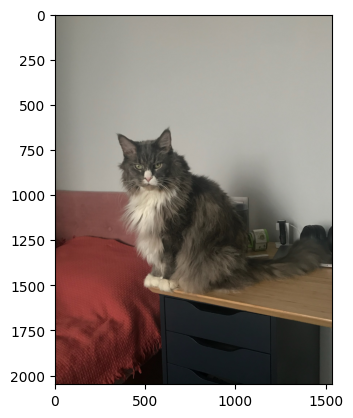

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

image = mpimg.imread('/content/ai/IMG_7615.JPG')
plt.imshow(image)
plt.show()

In [ ]:
# import torch
# torch.cuda.empty_cache()

In [ ]:
!accelerate launch /content/diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --instance_data_dir="/content/ai/" \
  --output_dir="/content/ailend_model/" \
  --instance_prompt="a photo of gray cat Ailend" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --checkpointing_steps=100 \
  --learning_rate=1e-4 \
  --report_to="wandb" \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=500 \
  --validation_prompt="a photo of gray cat Ailend" \
  --validation_epochs=50 \
  --seed="0" \
  --push_to_hub

2023-05-14 14:45:45.055190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-14 14:45:50.177495: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:258: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
05/14/2023 14:45:52 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'prediction_type', 'thresholding', 'clip_sample_range', 'sample_max_value', 'dynamic_thresholding_ratio', 'variance_type'} was not found in config. Values will be initialized to default values.
{'scaling_factor'} was 

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

model_base = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(model_base, torch_dtype=torch.float16)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [ ]:
pipe.unet.load_attn_procs('/content/ailend_model/')
pipe.to("cuda")

image = pipe(
    "a photo of gray cat Ailend",
    num_inference_steps=25,
    guidance_scale=7.5,
    cross_attention_kwargs={"scale": 0.5},
).images[0]

image = pipe("a photo of gray cat Ailend", num_inference_steps=25, guidance_scale=7.5).images[0]
image.save("island.png")

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
pipe.unet.load_attn_procs('/content/ailend_model/')
pipe.to("cuda")

image = pipe(
    "cat Ailend in Van Gogh style",
    num_inference_steps=25,
    guidance_scale=7.5,
    cross_attention_kwargs={"scale": 0.5},
).images[0]

image = pipe("cat Ailend in Van Gogh style", num_inference_steps=25, guidance_scale=7.5).images[0]
image.save("cart_island.png")

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

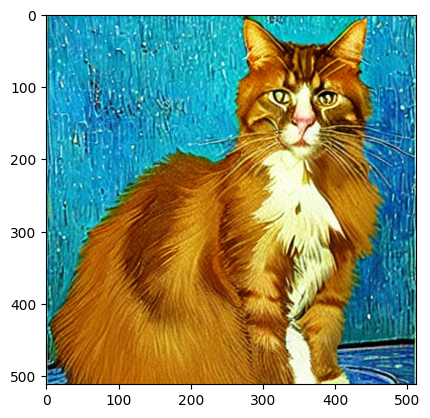

In [ ]:
image = mpimg.imread("cart_island.png")
plt.imshow(image)
plt.show()

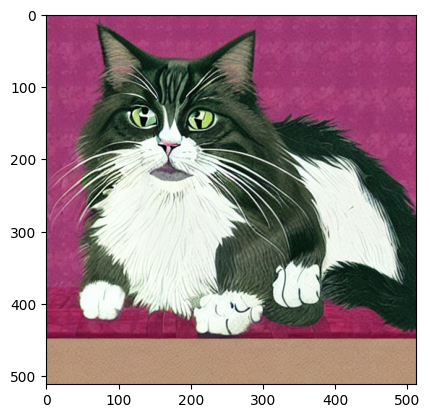

In [ ]:
image = mpimg.imread("cart_island.png")
plt.imshow(image)
plt.show()

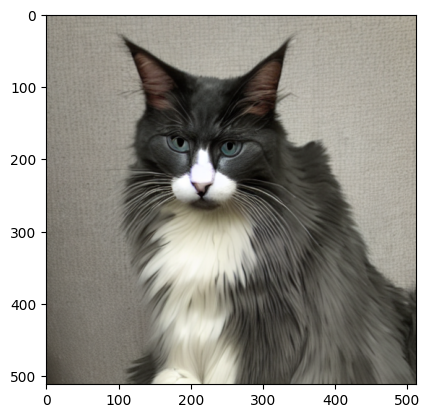

In [ ]:
image = mpimg.imread("island.png")
plt.imshow(image)
plt.show()

## References 
- [LoRA](https://huggingface.co/docs/diffusers/training/lora)

- [Text-to-image pipeline](https://huggingface.co/docs/diffusers/v0.16.0/en/api/pipelines/stable_diffusion/text2img#diffusers.StableDiffusionPipeline)

- [FineTuning](https://huggingface.co/docs/diffusers/training/text2image)

- [Diffusers](https://github.com/huggingface/diffusers)

- [Tricks to train big models](https://colab.research.google.com/github/oseledets/dl2023/blob/main/seminars/seminar-10/Large_model_training_practice.ipynb)